In [83]:
import nltk
import nltk.sentiment
import numpy as np
import json
import pickle
import timeit
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import re

In [7]:
f = open("stopwords_list.dat")
stopwords = set([word.strip().lower() for word in f.readlines()])
f.close()

In [8]:
devfile = "../A1_Data/dev.json"
trainfile = "../A1_Data/train.json"

### Pickling TFIDF vectors with preprocessing

In [62]:
cap_block = re.compile('[A-Z][A-Z][A-Z]+')
money = re.compile('-?\$\d+\.*\d*')
numeral = re.compile('-?\d+\.*\d*')

In [63]:
def preprocess(text):
    # tokenize
    text = nltk.word_tokenize(text.lower())
    # remove stopwords
    text = [word for word in text if word not in stopwords]
    # propogate negation
    text = nltk.sentiment.util.mark_negation(text)
    # remove punctuations ONLY after removing negation
    text = [word for word in text if word not in [".","?",","]]
    return text + ["CAP_BLOCK"]*cap_block_found

In [64]:
vectorizer = TfidfVectorizer(tokenizer=preprocess, min_df=5, lowercase=False)

In [65]:
train_data = []
train_labels = []
f = open(trainfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    train_data.append(json_dump["review"])
    train_labels.append(json_dump["ratings"])
f.close()

In [66]:
start = timeit.default_timer()
feature_vector = vectorizer.fit_transform(train_data)
print(feature_vector.shape)
print(timeit.default_timer()-start)

(1000000, 110770)
840.041870815


In [67]:
pickle.dump(feature_vector,open("preproc_tfidf_train_vector.pickle", "wb"))
pickle.dump(vectorizer,open("preproc_vectorizer.pickle", "wb"))

In [68]:
dev_data = []
dev_labels = []
f = open(devfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    dev_data.append(json_dump["review"])
    dev_labels.append(json_dump["ratings"])
f.close()

In [69]:
dev_feature_vector = vectorizer.transform(dev_data)
dev_feature_vector.shape

(200000, 110770)

In [70]:
pickle.dump(dev_feature_vector,open("preproc_tfidf_dev_vector.pickle", "wb"))

In [71]:
del train_data
del dev_data

### Train Model

In [72]:
feature_vector = pickle.load(open("preproc_tfidf_train_vector.pickle","rb"))

In [73]:
train_labels = []
f = open(trainfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    train_labels.append(json_dump["ratings"])
f.close()

In [74]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty="l2", multi_class='multinomial', solver="saga", max_iter=1000)

In [75]:
start = timeit.default_timer()
model.fit(feature_vector, train_labels)
print(timeit.default_timer()-start)

142.23007356200014


In [76]:
pickle.dump(model,open("preproc_logist_model.pickle", "wb"))

### Validation phase

In [80]:
dev_feature_vector = pickle.load(open("preproc_tfidf_dev_vector.pickle","rb"))

In [81]:
dev_labels = []
dev_data = []
f = open(devfile,"r")
while(True):
    s = f.readline()
    if (s==""):
        break
    json_dump = json.loads(s)    
    dev_labels.append(json_dump["ratings"])
    dev_data.append(json_dump["review"])
f.close()

In [84]:
conf_mat = np.zeros((5,5), dtype=int)
f = open("error_file","w")
for i in range(0,len(dev_labels),1000):
    fv = dev_feature_vector[i:i+1000]
    y_pred = model.predict(fv)
    conf_mat+= confusion_matrix(y_pred, dev_labels[i:i+1000])
    
    for p in range(1000):
        if  abs(y_pred[p]-dev_labels[i+p])>2:
            f.write("Gold: %.1f, Predicted: %.1f, Review: %s\n"%(dev_labels[i+p], y_pred[p], dev_data[i+p].replace('\n','\\n')))
conf_mat

array([[25215,  5337,  1622,   541,   680],
       [ 2715,  5703,  2719,   446,   141],
       [  788,  3567,  9312,  3581,   612],
       [  306,   910,  6515, 21871,  9932],
       [  765,   622,  1948, 17567, 76585]])

In [85]:
print("Accuracy: \t",conf_mat.trace()/len(dev_data))
score = 0
for i in range(5):
    for j in range(5):
        score+=conf_mat[i][j]*((i-j)**2)
print("Cost: \t\t",score)

Accuracy: 	 0.69343
Cost: 		 114847


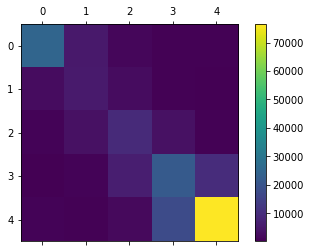

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat)
fig.colorbar(cax)